## Application: Hedonic Price Function of Houses
---

### Dependent variable

+ price    - sale price of a house

### Independent variables

+ lotsize  - lot size of a property in square feet
+ bedrooms - number of bedrooms
+ bathrms  - number of full bathrooms
+ stories  - number of stories excluding basement
+ driveway - does the house has a driveway?
+ recroom  - does the house has a recreational room?
+ fullbase - does the house has a full finished basement?
+ gashw    - does the house uses gas for hot water heating?
+ airco    - does the house has central air conditioning?
+ garagepl - number of garage places
+ prefarea - is the house located in the preferred neighbourhood of the city?

### Source:

Sales Prices of Houses in the City of Windsor

Anglin, P.M. and R. Gencay (1996) “Semiparametric estimation of a hedonic price function,” Journal of Applied Econometrics, 11(6), 633-648.

https://vincentarelbundock.github.io/Rdatasets/datasets.html


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from IPython.display import display
pd.set_option('future.no_silent_downcasting', True)

### Hedonic regression model

\begin{align*}
 \log(\text{price})
 &= \text{constant}
 + \beta_1\ \log(\text{lotsize})
 + \beta_2\ \text{bedrooms}
 + \beta_3\ \text{bathrms}
 + \beta_4\ \text{stories}
 + \beta_5\ \text{driveway} \\
 &\quad + \beta_6\text{recroom}
 + \beta_7\ \text{fullbase}
 + \beta_8\ \text{gashw}
 + \beta_9\ \text{airco}
 + \beta_{10}\ \text{garagepl}
 + \beta_{11}\ \text{prefarea}
 + \text{error}.
\end{align*}

In [2]:
data = pd.read_csv('Housing.csv', index_col=0)
display(data)

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
1,42000.0,5850,3,1,2,yes,no,yes,no,no,1,no
2,38500.0,4000,2,1,1,yes,no,no,no,no,0,no
3,49500.0,3060,3,1,1,yes,no,no,no,no,0,no
4,60500.0,6650,3,1,2,yes,yes,no,no,no,0,no
5,61000.0,6360,2,1,1,yes,no,no,no,no,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...
542,91500.0,4800,3,2,4,yes,yes,no,no,yes,0,no
543,94000.0,6000,3,2,4,yes,no,no,no,yes,0,no
544,103000.0,6000,3,2,4,yes,yes,no,no,yes,1,no
545,105000.0,6000,3,2,2,yes,yes,no,no,yes,1,no


In [3]:
column_names = data.columns
qualitative = ['driveway', 'recroom', 'fullbase', 'gashw', 'airco', 'prefarea']
data[qualitative] = data[qualitative].replace({'yes':1, 'no':0})
data['lotsize'] = np.log(data['lotsize'])
display(data)

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
1,42000.0,8.674197,3,1,2,1,0,1,0,0,1,0
2,38500.0,8.294050,2,1,1,1,0,0,0,0,0,0
3,49500.0,8.026170,3,1,1,1,0,0,0,0,0,0
4,60500.0,8.802372,3,1,2,1,1,0,0,0,0,0
5,61000.0,8.757784,2,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
542,91500.0,8.476371,3,2,4,1,1,0,0,1,0,0
543,94000.0,8.699515,3,2,4,1,0,0,0,1,0,0
544,103000.0,8.699515,3,2,4,1,1,0,0,1,1,0
545,105000.0,8.699515,3,2,2,1,1,0,0,1,1,0


In [4]:
price = data['price'].to_numpy(dtype='float64')
features = data[column_names[1:]].to_numpy(dtype='float64')
y = np.log(price)
X = np.hstack((np.ones((len(price), 1)), features))
var_names = np.concatenate((['constant'], column_names[1:], ['$\\sigma^2$']))

The prior distribution of $\beta$ and $\sigma^2$ are

\begin{align*}
 \beta &\sim \mathrm{Normal}\left(\mu_\beta,\Sigma_\beta\right), \\
 \sigma^2 &\sim \mathrm{Inv.Gamma}\left(\frac{\nu_0}{2},\frac{\lambda_0}{2}\right).
\end{align*}

We set

$$
 \mu_{\beta} = \begin{bmatrix} 0 \\ \vdots \\ 0 \end{bmatrix},\ 
 \Sigma_{\beta} = 
 \begin{bmatrix} 100 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & 100 \end{bmatrix},\ 
 \nu_0 = 0.02,\ \lambda_0 = 0.02.
$$


In [5]:
k = X.shape[1]
mu_b, Sigma_b, nu0, lam0 = np.zeros(k), 100.0 * np.eye(k), 0.02, 0.02

### Model setup

In the with statement, `y_data` and `X_data` are data variables that contain `y` and `X` respectively, the prior distribution of $\sigma^2$ is the same inverse gamma distribution and the prior distribution of the regression coefficients $\beta$ is spacified as the following $k$-dimensional multivariate normal distribuiton.

```Python
    b = pm.MvNormal('b', mu=mu_b, cov=Sigma_b, shape=k)
```

where `mu` is the mean vector, `cov` is the covariance matrix, and `shape` is the demension of the distribution.

The follwoing line computes the product of a matrix `X_data` and a vector `b`, which is the conditional expectation of `y` given `X`.

``` Python
    y_hat = X_data @ b
 ```


In [6]:
multiple_regression = pm.Model()
with multiple_regression:
    y_data = pm.Data('y_data', y)
    X_data = pm.Data('X_data', X)
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    b = pm.MvNormal('b', mu=mu_b, cov=Sigma_b)
    y_hat = X_data @ b
    likelihood = pm.Normal('y', mu=y_hat, sigma=pm.math.sqrt(sigma2), observed=y_data)

### Markov chain sampling


In [7]:
n_draws, n_chains, n_tune = 5000, 4, 1000
with multiple_regression:
    # trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123) # PyMC default sampler (very slow)
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123, nuts_sampler='numpyro') # numpyro (much faster but does not work on Colab)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [8]:
results = pm.summary(trace, hdi_prob=0.95)
results.index = var_names
sim_param = dict([(var, trace.posterior['b'].to_numpy()[:, :, index]) for index, var in enumerate(var_names[:-1])])
sim_param[var_names[-1]] = trace.posterior['sigma2'].to_numpy()
display(results)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
constant,7.741,0.215,7.325,8.166,0.002,0.002,7900.0,11554.0,1.0
lotsize,0.304,0.027,0.250,0.354,0.000,0.000,7743.0,11041.0,1.0
bedrooms,0.035,0.014,0.006,0.062,0.000,0.000,16178.0,15320.0,1.0
bathrms,0.166,0.020,0.125,0.205,0.000,0.000,19020.0,14445.0,1.0
stories,0.092,0.013,0.067,0.116,0.000,0.000,16594.0,15725.0,1.0
driveway,0.111,0.028,0.055,0.165,0.000,0.000,16281.0,13898.0,1.0
recroom,0.058,0.026,0.007,0.109,0.000,0.000,17316.0,15121.0,1.0
fullbase,0.104,0.022,0.062,0.147,0.000,0.000,16963.0,15206.0,1.0
gashw,0.179,0.044,0.091,0.263,0.000,0.000,19354.0,15133.0,1.0
airco,0.166,0.021,0.125,0.208,0.000,0.000,18775.0,14892.0,1.0


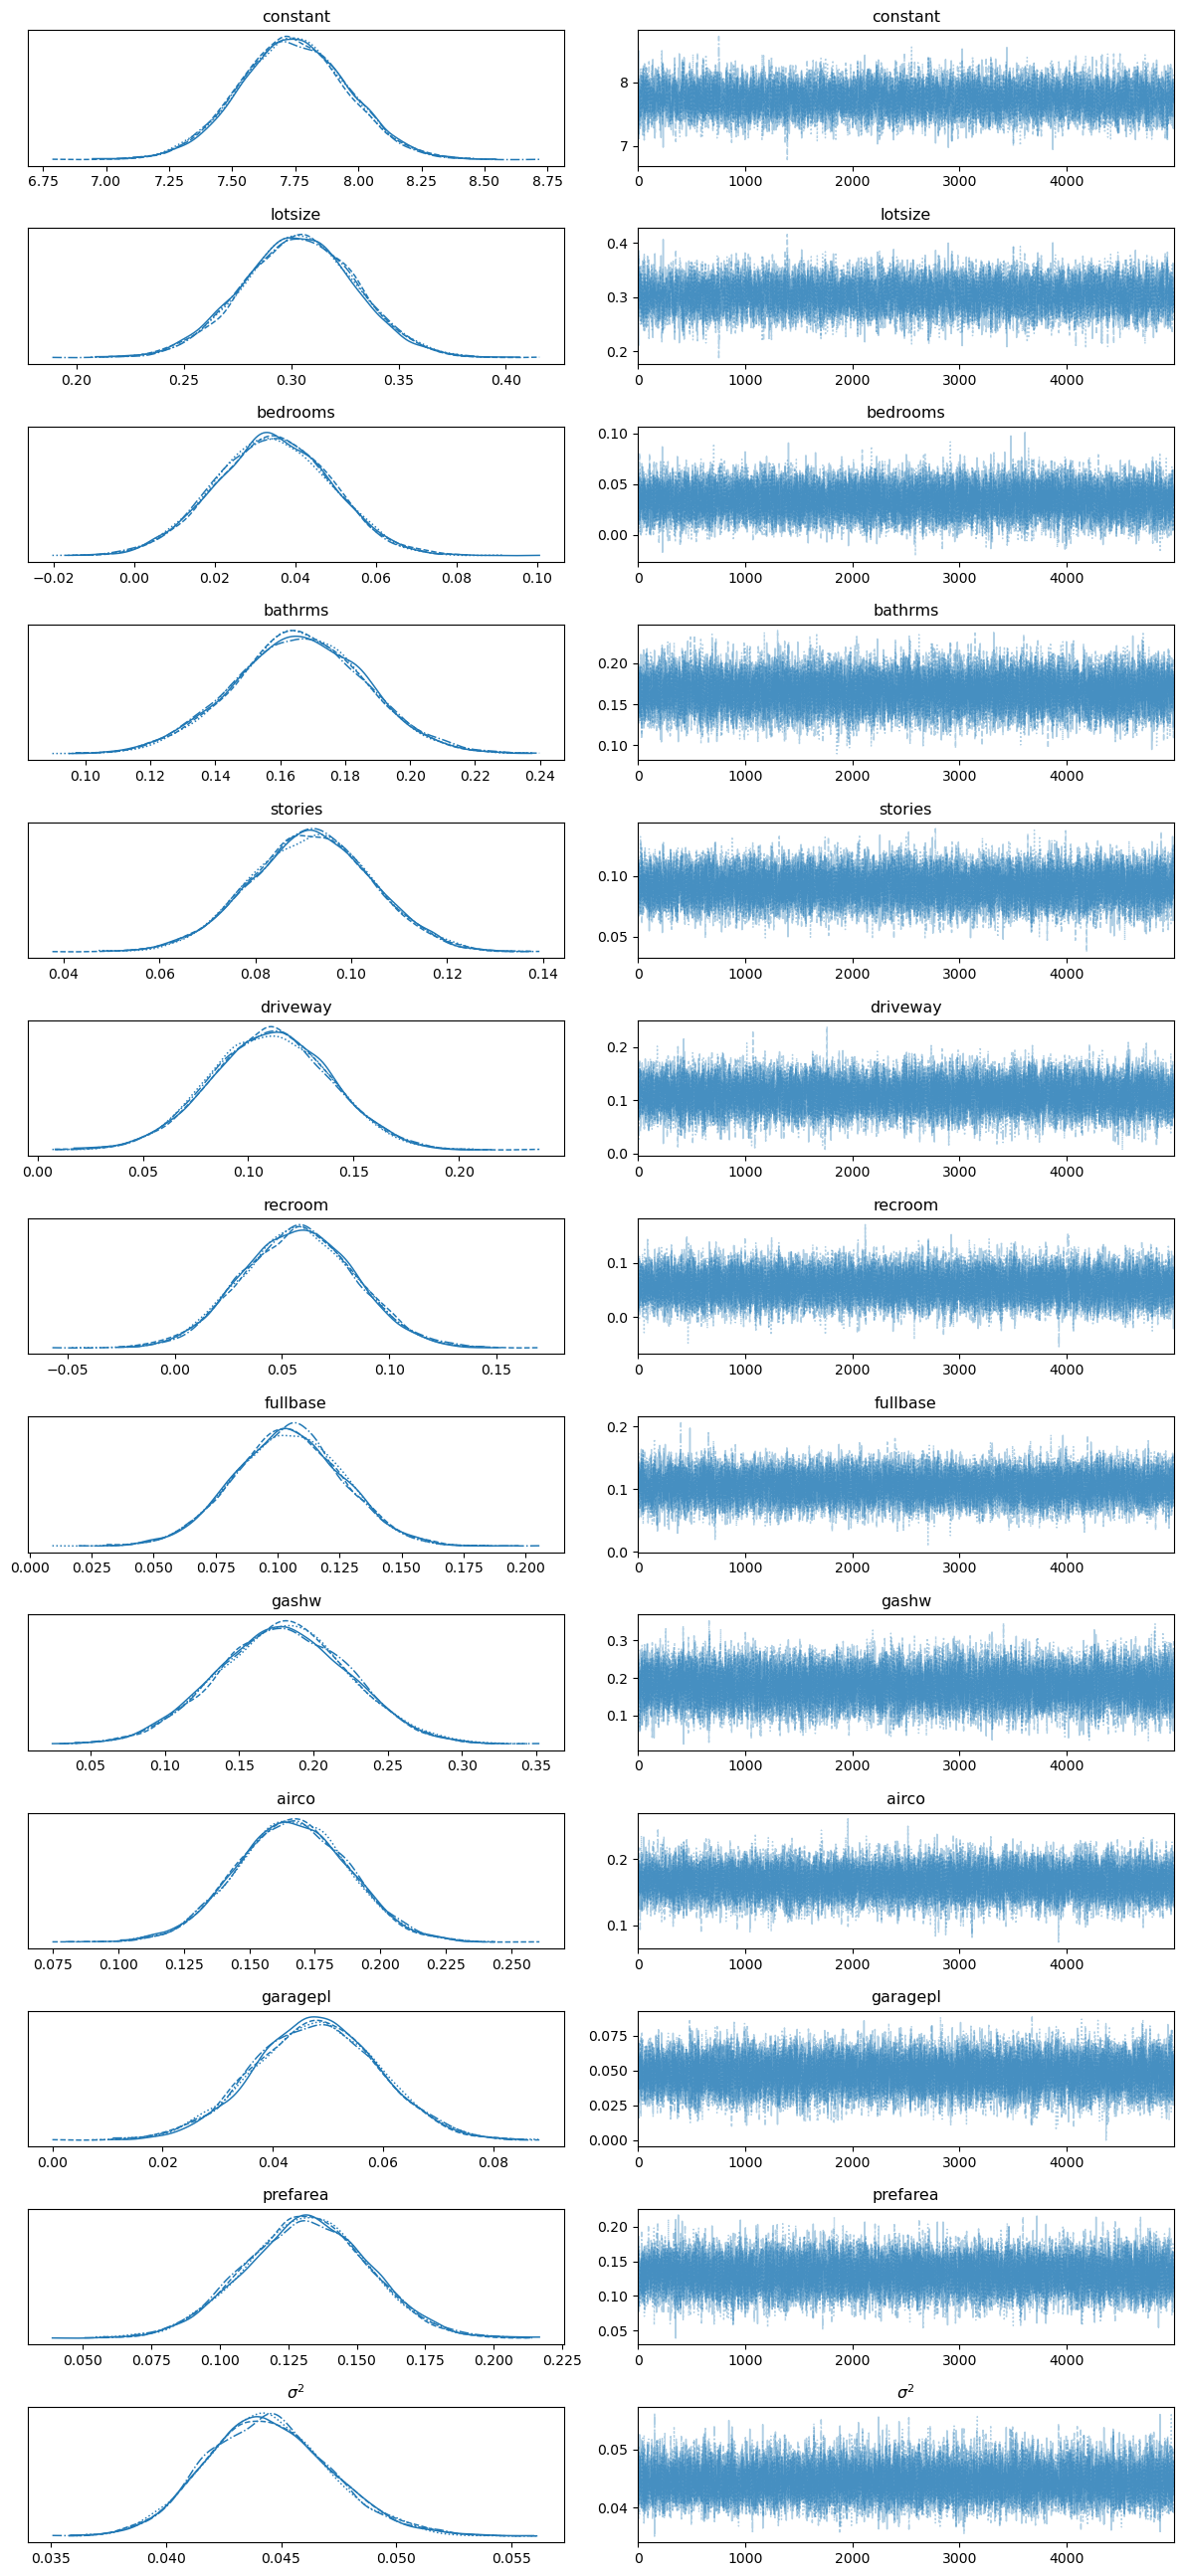

In [9]:
pm.plot_trace(sim_param)
plt.tight_layout()
plt.show()

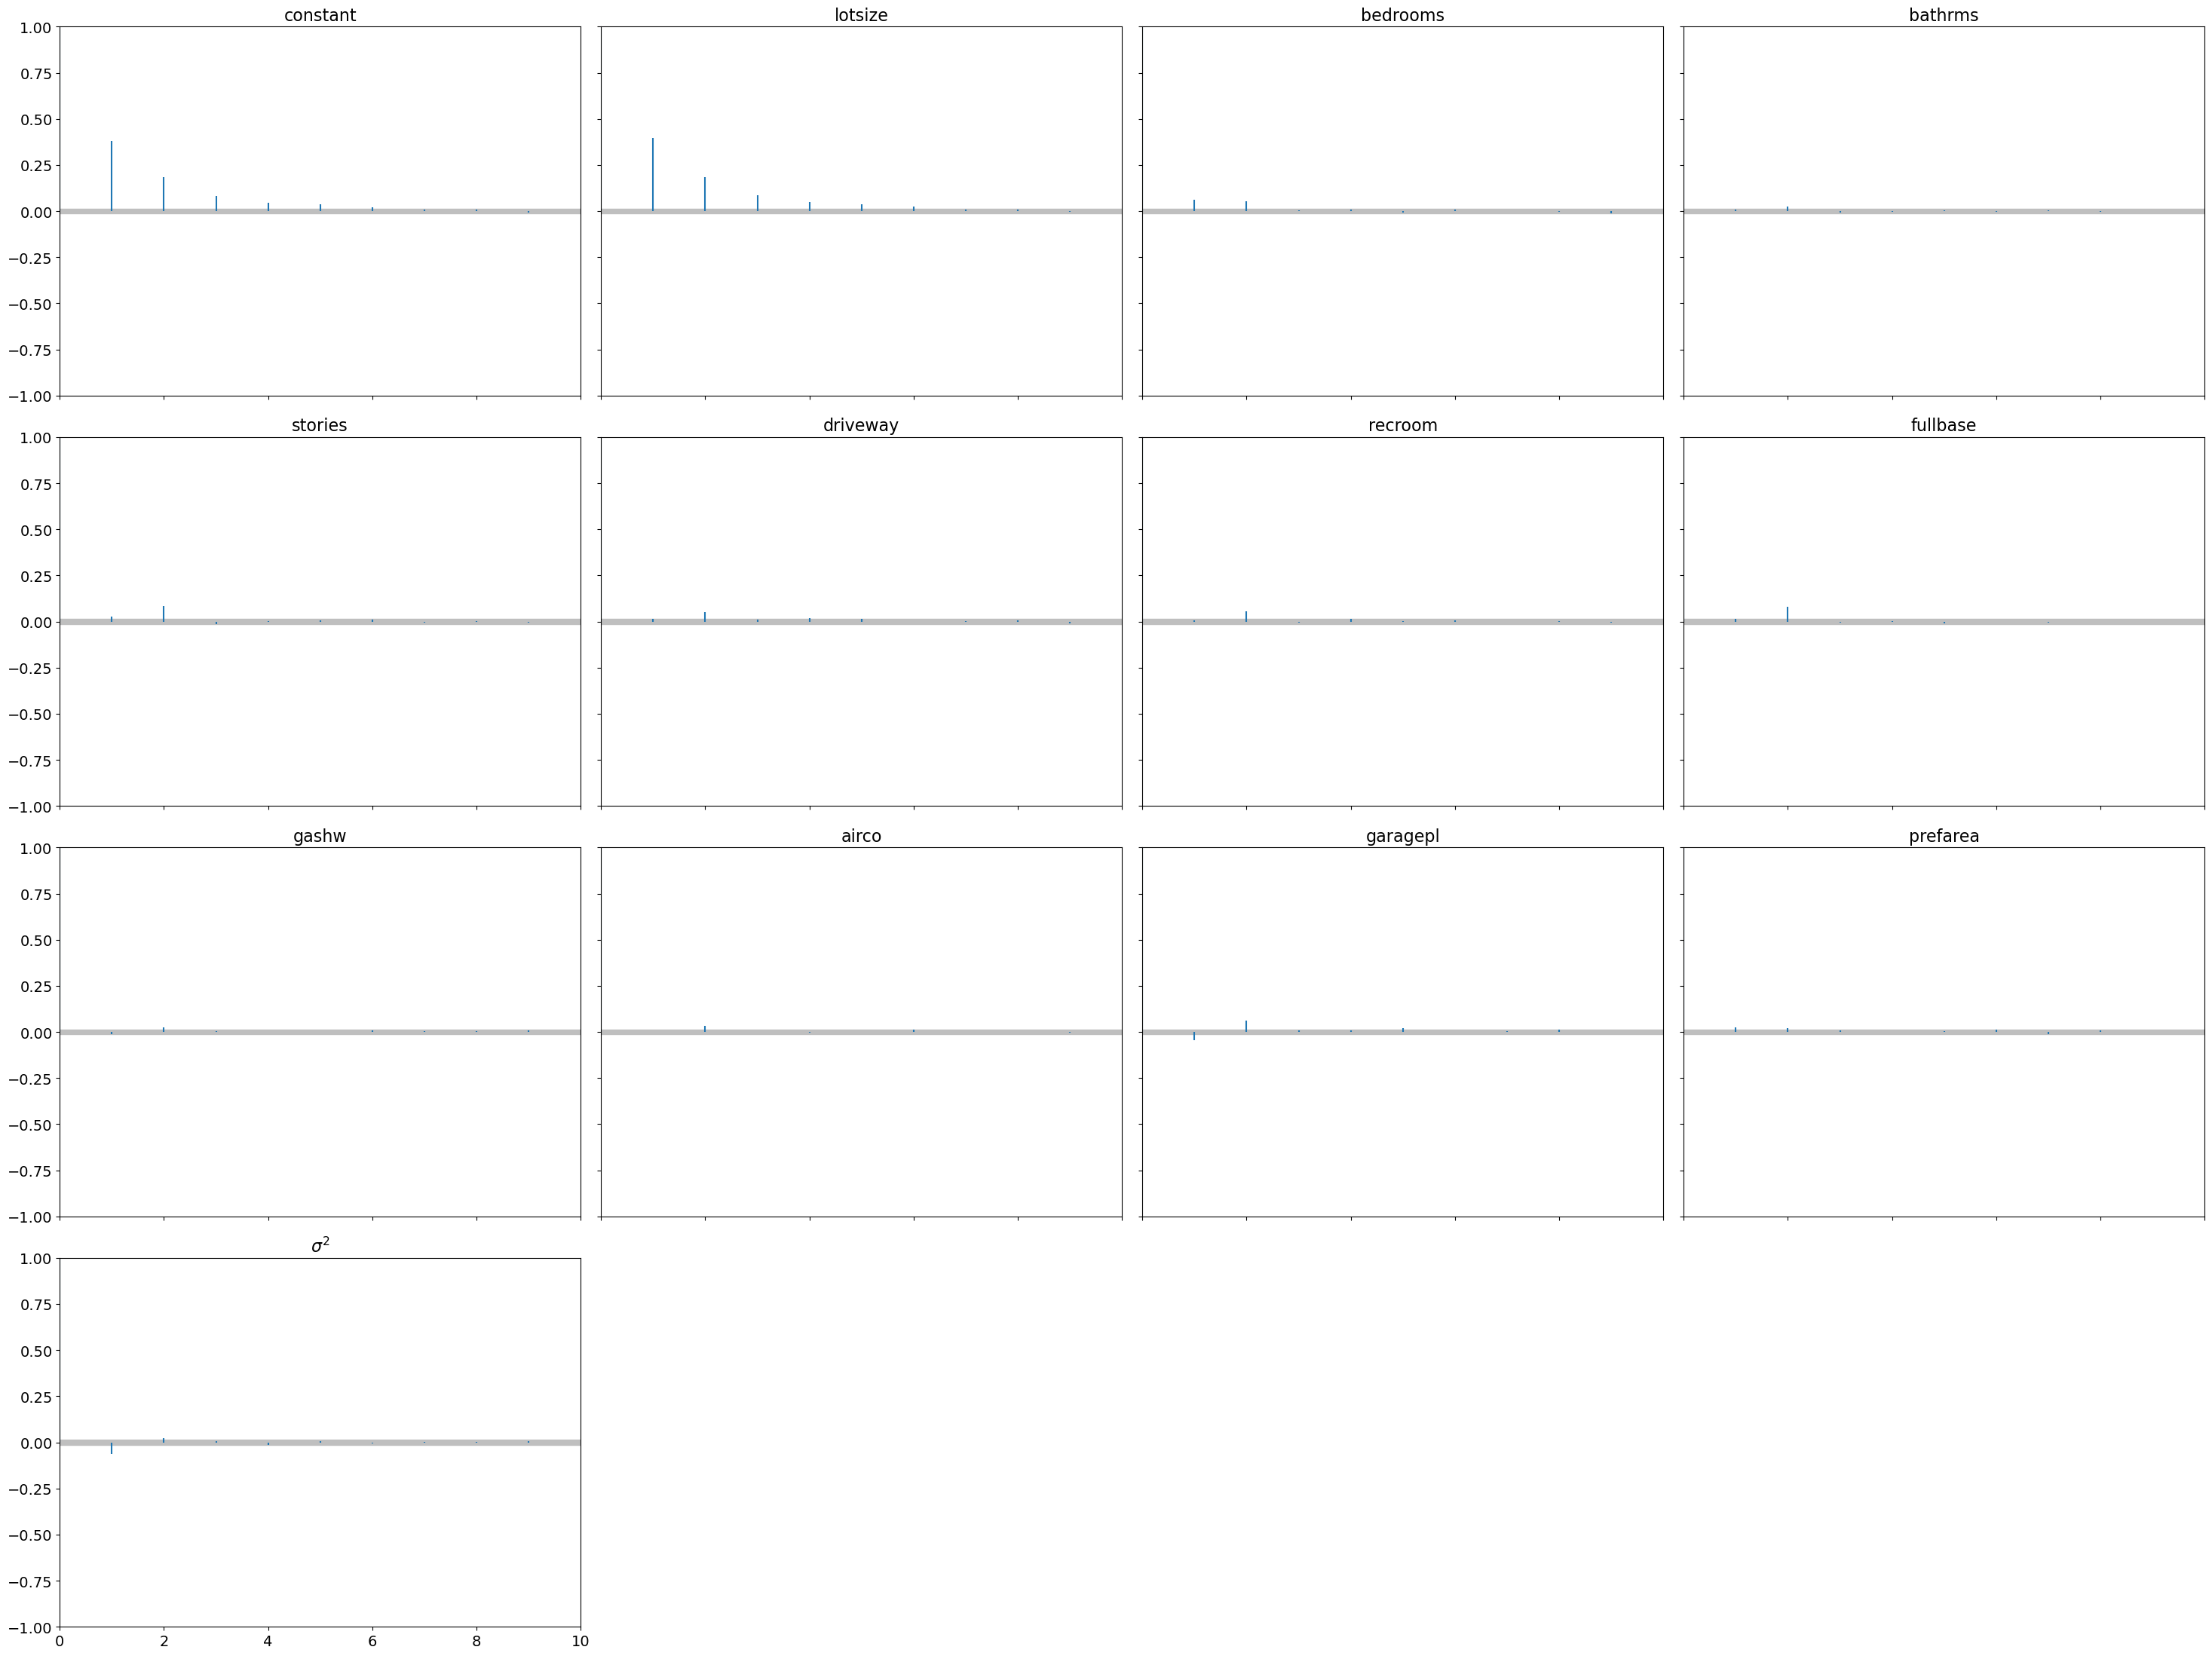

In [10]:
pm.plot_autocorr(sim_param, max_lag=10, combined=True)
plt.tight_layout()
plt.show()

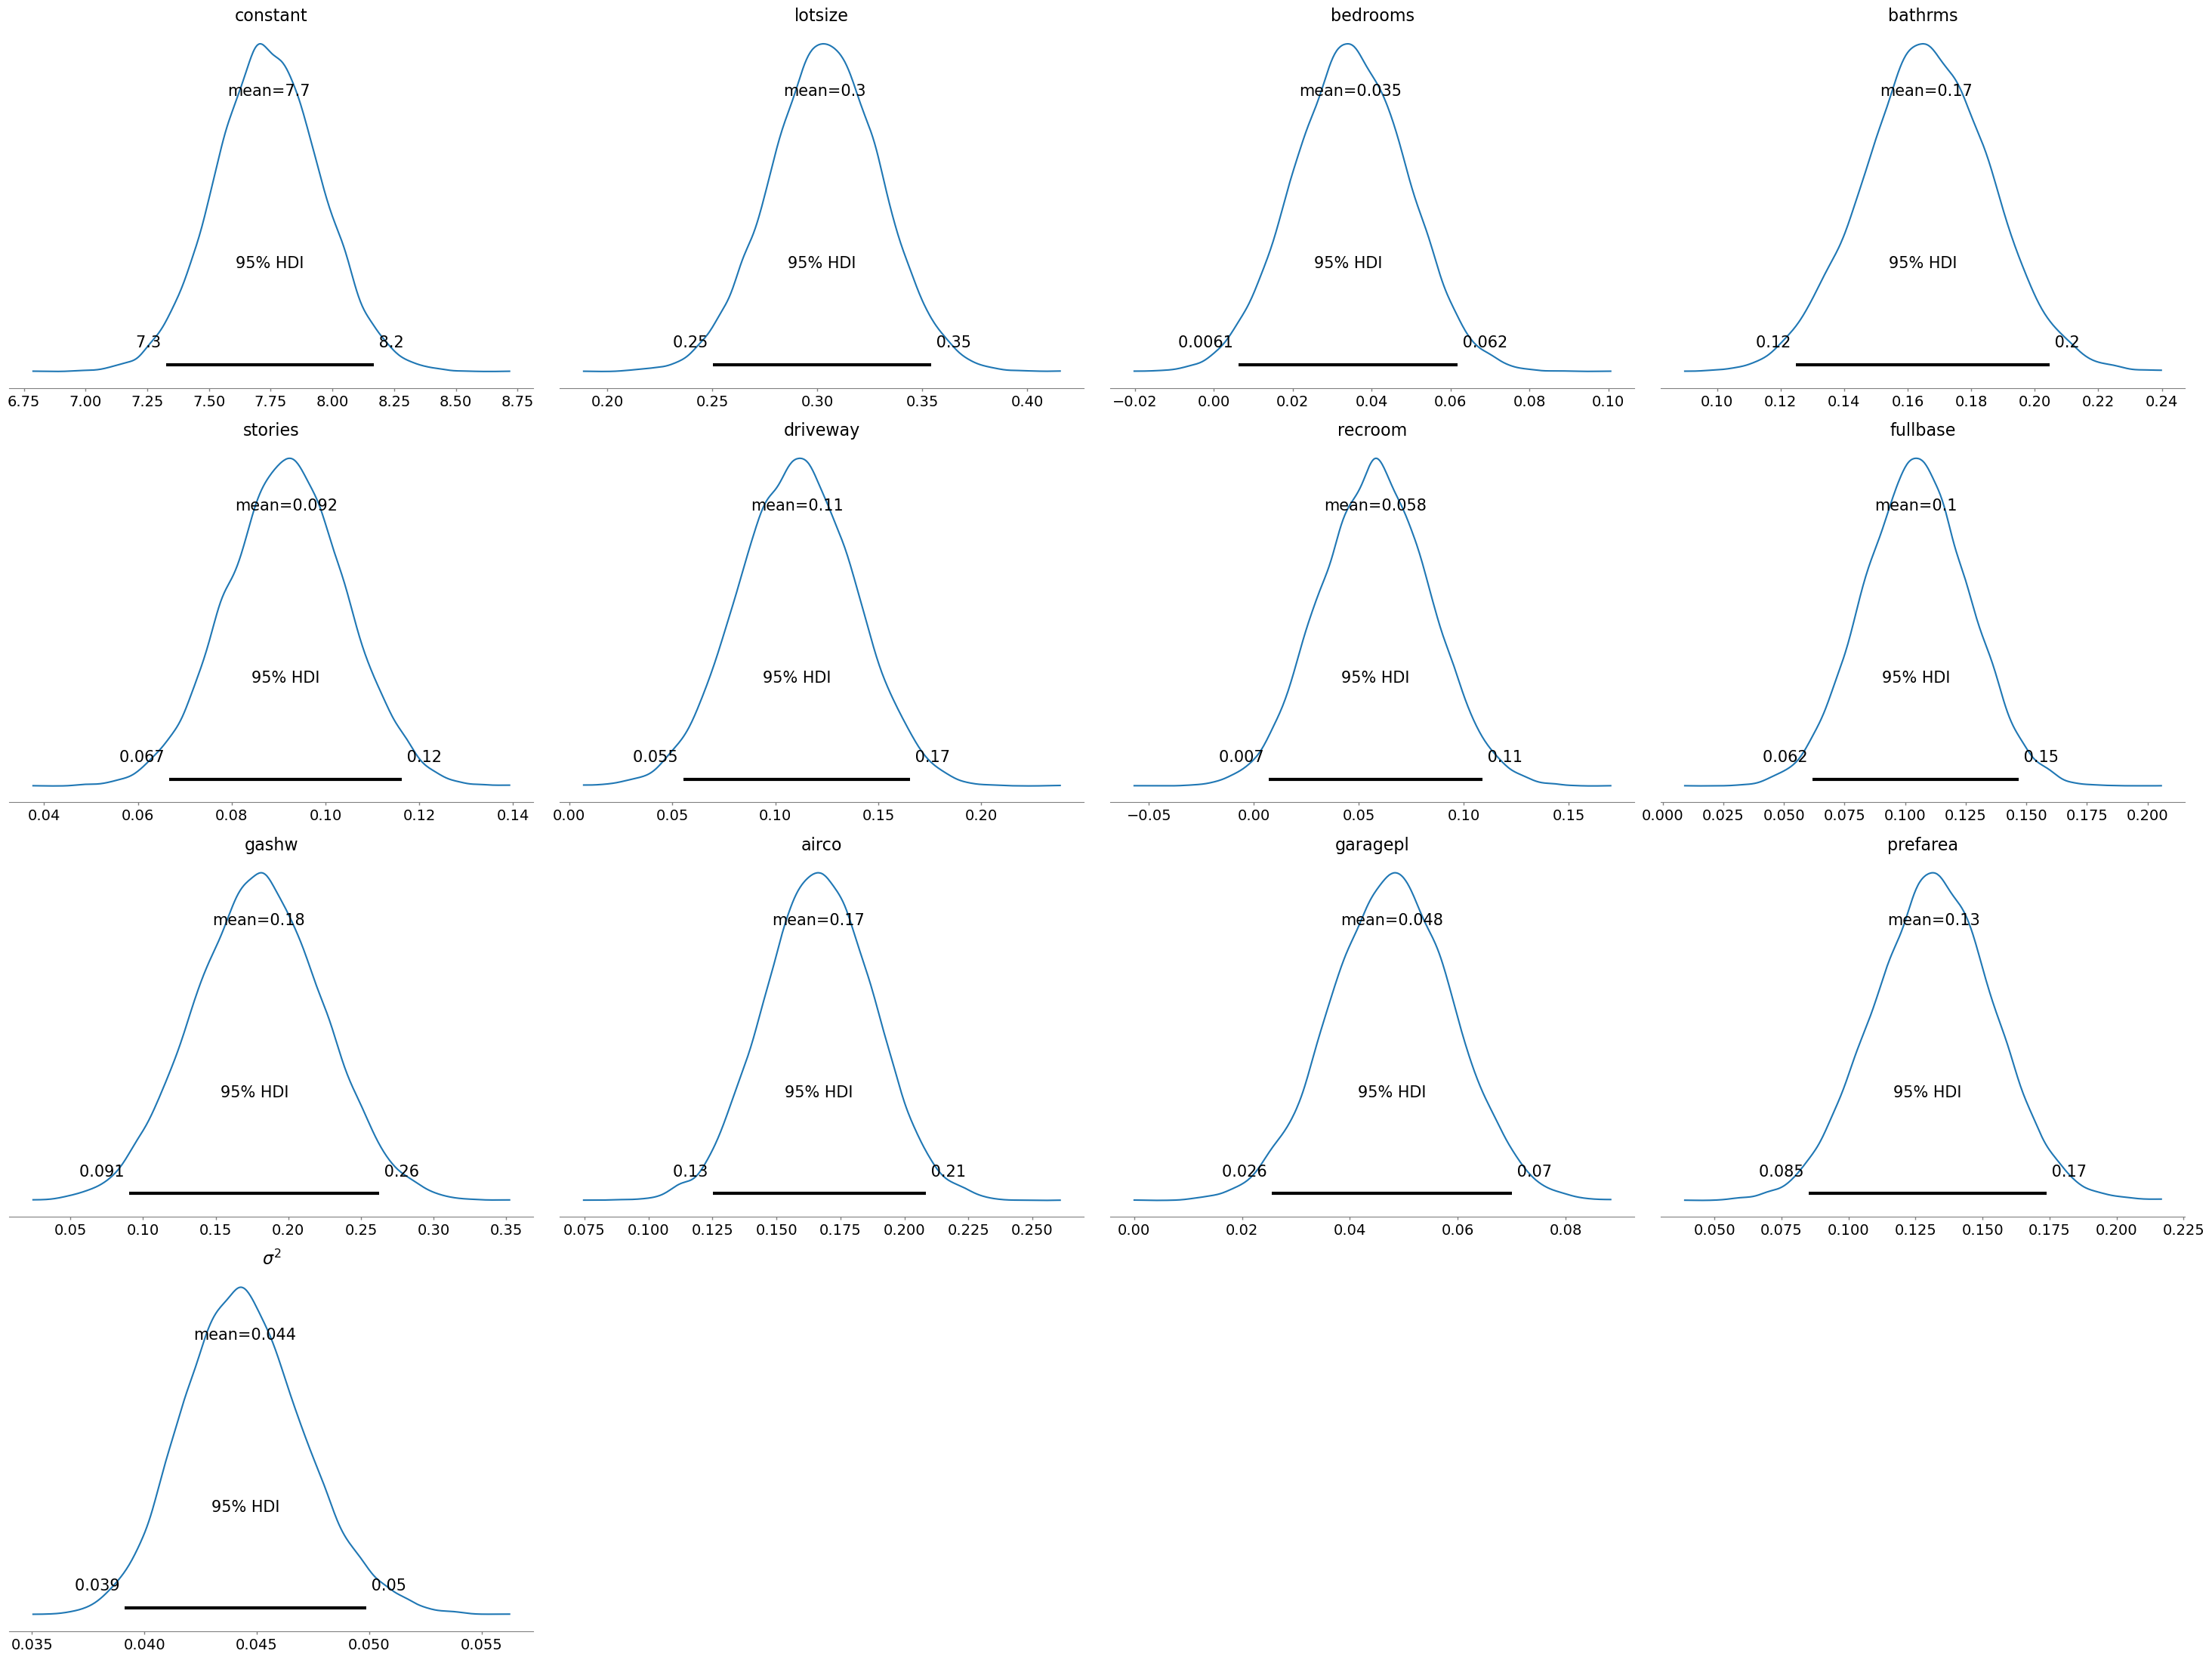

In [11]:
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()